In [8]:
import numpy as np
from matplotlib import pyplot as plt

# import dustpy as dp
from dustpy import Simulation
from dustpy import constants as c

from dustpy_kernels import *

# create simulation
sim = Simulation()
sim.ini

namespace(dust=namespace(aIniMax=0.0001,
                         allowDriftingParticles=False,
                         erosionMassRatio=10.0,
                         d2gRatio=0.01,
                         distExp=-3.5,
                         excavatedMass=1.0,
                         fragmentDistribution=-1.8333333333333333,
                         rhoMonomer=1.67,
                         vfrag=100.0),
          gas=namespace(alpha=0.001,
                        gamma=1.4,
                        Mdisk=9.942049353490256e+31,
                        mu=3.847030424486999e-24,
                        SigmaExp=-1.0,
                        SigmaRc=897587224200000.0),
          grid=namespace(Nmbpd=7,
                         mmin=1e-12,
                         mmax=100000.0,
                         Nr=100,
                         rmin=14959787070000.0,
                         rmax=1.495978707e+16),
          star=namespace(M=1.988409870698051e+33, R=139140000000.0, T=5772.0))

In [9]:
# Change ini params

sim.ini.dust.allowDriftingParticles = False
sim.ini.grid.Nr = 3
sim.ini.grid.Nmbpd = 28

sim.ini

namespace(dust=namespace(aIniMax=0.0001,
                         allowDriftingParticles=False,
                         erosionMassRatio=10.0,
                         d2gRatio=0.01,
                         distExp=-3.5,
                         excavatedMass=1.0,
                         fragmentDistribution=-1.8333333333333333,
                         rhoMonomer=1.67,
                         vfrag=100.0),
          gas=namespace(alpha=0.001,
                        gamma=1.4,
                        Mdisk=9.942049353490256e+31,
                        mu=3.847030424486999e-24,
                        SigmaExp=-1.0,
                        SigmaRc=897587224200000.0),
          grid=namespace(Nmbpd=28,
                         mmin=1e-12,
                         mmax=100000.0,
                         Nr=3,
                         rmin=14959787070000.0,
                         rmax=1.495978707e+16),
          star=namespace(M=1.988409870698051e+33, R=139140000000.0, T=5772.0))

In [10]:
# Initialize and run test coagulation simulation with constant kernel

sim.initialize()

a = 1.
S0 = 1.

set_constant_kernel(sim, a, S0)

snapshots = np.logspace(-7., 3., 6)
sim.t.snapshots = snapshots

sim.writer.datadir = "outputs/test_constant_kernel"

sim.run()


DustPy v1.0.5

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  5.90e-14
        for particle collision
            m[443] =  6.63e+03 g    with
            m[472] =  7.20e+04 g
    - Full fragmentation:
        max. rel. error:  1.11e-15
        for particle collision
            m[226] =  1.18e-04 g    with
            m[233] =  2.10e-04 g
    - Erosion:
        max. rel. error:  5.44e-15
        for particle collision
            m[431] =  2.47e+03 g    with
            m[462] =  3.16e+04 g

Creating data directory 'outputs/test_constant_kernel'.
Writing file outputs/test_constant_kernel/data0000.hdf5
Writing dump file outputs/test_constant_kernel/frame.dmp
Writing file outputs/test_constant_kernel/data0001.hdf5
Writing dump file outputs/test_constant_kernel/frame.d

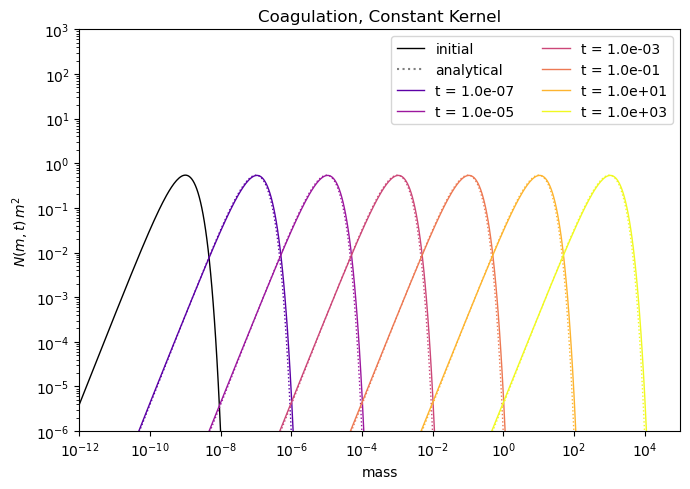

In [22]:
# Output / Plot

SigmaConstant = sim.writer.read.sequence("dust.Sigma")
m = sim.writer.read.sequence("grid.m")
t = sim.writer.read.sequence("t")

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.loglog(m[0, ...], convert(SigmaConstant[0, 1, :], m[0, ...]), lw=1, c="black", label="initial")
ax.plot(0., 0., ":", c="black", label="analytical", alpha=0.5)

couleurs = plt.cm.plasma(np.linspace(0,1,len(t)))
for i in range(1, len(t)):
    cstr = couleurs[i] # "C" + str(i-1)
    ax.loglog(m[i,:], convert(SigmaConstant[i,1,:], m[i,:]), lw=1, c=cstr, label="t = {:3.1e}".format(t[i]))
    ax.loglog(m[i,:], solution_constant_kernel(t[i], m[i,:], a, S0), ":", lw=1, c=cstr)

ax.legend(ncol=2)
ax.set_xlim(m[0, 0], m[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"mass")
ax.set_ylabel(r"$N\left(m,t\right)\,m^2$")
ax.set_title(r"Coagulation, Constant Kernel")
fig.tight_layout()
plt.show()